<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import matplotlib
import statsmodels.tools.eval_measures as bias
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from mpl_toolkits.mplot3d import Axes3D # Axes3D import has side effects, it enables using projection='3d' in add_subplot
from math import ceil
from scipy import linalg
from os import listdir
from numpy.random import uniform, normal
from numpy.linalg import *
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_regression import KernelReg

In [138]:
def dibuja_hist2(df,colour,name,Xlabel,Ylabel,title):
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
    plt.figure()
    df.hist(column=0, bins=25, grid=False, figsize=(6,3), color=colour, zorder=2, rwidth=0.9)
    plt.xticks(rotation=90)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    #https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors/42020486
    mytitle = plt.title(title) # get the title property handler   #plt.getp(title_obj)  
    plt.setp(mytitle, color='#ff8000')                            # set the color of title
    myax = plt.axes()   # get the axis property handler           # plt.getp(myax) print its propieties
    myax.xaxis.label.set_color('#ff8000')
    myax.yaxis.label.set_color('#ff8000')
    myax.tick_params(colors='#ff8000', which='both')              # myax.spines['bottom'].set_color('yellow')
    plt.savefig(name, transparent=True)
    myax.spines['bottom'].set_color(LETRASNARA)
    myax.spines['top'   ].set_color(LETRASNARA) 
    myax.spines['right' ].set_color(LETRASNARA)
    myax.spines['left'  ].set_color(LETRASNARA)
    plt.show()                                                    # o plt.save_en_algún_formato()

In [139]:
def dibuja_lineas(x, ylist, labels, namefile, Xlabel, Ylabel, title):    
    #https://matplotlib.org/3.1.1/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
    name = 'fig_t7_4'
    colors     = [CYAN,'r',LILA,VERDE,AZUL,'b','g']
    markers    = ['o','o','o','o','o','o','o']
    linestyles = ['--','-','--','-.','-.',':',':']
    fig, ax = plt.subplots(figsize=(7,6))

    for i in range(len(ylist)):
        plt.plot(x, ylist[i], linestyle=linestyles[i], marker=markers[i], label=labels[i], color=colors[i])

    plt.gcf().set_size_inches(7, 4)
    plt.xlabel(Xlabel,fontsize='large',color = LETRASNARA)
    plt.ylabel(Ylabel,fontsize='large',color = LETRASNARA)
    plt.title(title  ,fontsize='x-large',color = LETRASNARA)
    plt.legend(fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax.spines['bottom'].set_color(LETRASNARA)
    ax.spines['top'   ].set_color(LETRASNARA) 
    ax.spines['right' ].set_color(LETRASNARA)
    ax.spines['left'  ].set_color(LETRASNARA)
    plt.savefig(namefile, transparent=True)
    plt.show()

In [140]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

Esta función calcula los pesos de los puntos $x_i\in\mathcal{Rp}$ del vecindario alrededor del punto $x_o\in\mathcal{Rp}$. Se da mayor peso a las puntos $x_i$ mas cercanos al punto $x_o$ y menos peso a las observaciones más lejanas utilizando un kernel que asigna importancia a cada uno de los k vecinos de $x_i$ según su distancia a $x_o$.

In [141]:
# Calcula los pesos y regresa una matriz diagonal con los pesos
def get_weight_exp(xo, X, k): 
## k    : tamanio del vecindario (bandwidth)
## X    : Regresores
## xo   : punto donde se desea hacer la predicción.

    n = X.shape[0]             ## numero de datos
    weight = np.mat(np.eye(n)) ## Matriz de pesos identidad W.
    
  # Cálculo de pesos para todos los datos de entrenamiento xi.
    for i in range(n): 
        xi = X[i] 
        d = (-2 * k * k) 
        weight[i, i] = np.exp(np.dot((xi-xo), (xi-xo).T)/d) 
        
    return weight

A continuación estimamos los coeficientes de regresión `β = (Xt W(xo) X)^{-1}) (Xt W Y)` con la matrix de pesos `W`.

In [142]:
def local_regression(X,W,Xo):
    # W     : Matriz diagonal de pesos
    # X     : Regresores
    # xo    : punto donde se desea hacer la predicción.
    Xt = X.T  # Calcula transpuesta de X
    A = np.matmul(Xt, np.matmul(W,X)) 
    A = np.linalg.inv(A)   # Calcula inversa de A
    B = np.matmul(Xt, np.matmul(W,Y)) 
    beta = np.matmul(A,B)
    prediccion = np.matmul(Xo,beta)
    return prediccion

A continuación haremos la comparación de resultados de regresión para datos de demanda eléctrica. La variable independiente `X` serán los datos de demanda del día anterior, y los datos independiente `Y` serán los datos de días con una mayor correlación con `X`. En esta sección, aplicaremos regresión lineal múltiple con multiples regresores `X`. Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)

## Muestreo **bootstrap** en estimación de error en la predicción de demanda eléctrica usando regresión líneal múltiple

In [143]:
df  = pd.read_csv('demanda.csv')
X   = pd.DataFrame(df[['X1','X2']]).to_numpy()
X   = pd.DataFrame(df[['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9']]).to_numpy()
Y   = pd.DataFrame(df[['Y']]).to_numpy()

A continuación se calcula un modelo de regresión lineal múltiple para una de las muestras `X_train` elegidas aleatoriamente un 50% de datos del total del conjunto `X`. Los datos de error (MAE) de todas las réplicas del muestreo aleatorio se guardan en la lista `bootstrap_ols`.

[[0    119.517762
dtype: float64, 0    119.400027
dtype: float64, 0    119.113542
dtype: float64, 0    119.417281
dtype: float64, 0    118.910511
dtype: float64, 0    118.36233
dtype: float64, 0    117.047043
dtype: float64, 0    116.753833
dtype: float64, 0    108.527916
dtype: float64], [0    119.416247
dtype: float64, 0    119.412507
dtype: float64, 0    119.14809
dtype: float64, 0    119.145994
dtype: float64, 0    118.866009
dtype: float64, 0    118.658369
dtype: float64, 0    117.284258
dtype: float64, 0    116.108489
dtype: float64, 0    110.235145
dtype: float64], [0    119.486123
dtype: float64, 0    119.347894
dtype: float64, 0    119.243274
dtype: float64, 0    119.067843
dtype: float64, 0    118.877276
dtype: float64, 0    118.230338
dtype: float64, 0    117.432896
dtype: float64, 0    116.195749
dtype: float64, 0    111.338469
dtype: float64], [0    119.510162
dtype: float64, 0    119.522095
dtype: float64, 0    119.476295
dtype: float64, 0    119.017774
dtype: float64, 0 

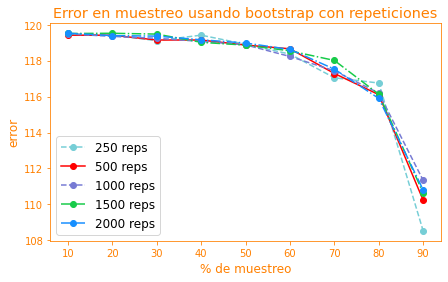

In [144]:
from numpy.ma.core import mean
percent   = [10,20,30,40,50,60,70,80,90] # porcentaje de muestreo
replicas  = [250,500,1000,1500,2000] # porcentaje de muestreo 1500,2000,2500,5000
test      = []
ylist     = []

for rep in replicas:
    mean      = []
    desv_up   = []
    desv_down = []
    for per in percent:
        bootstrap_ols= []
        for rep in range(rep):
            a = np.arange(0,X.shape[0])
            b = np.sort(np.random.choice(a, replace=False, size = int(len(a) * (per/100))))
            X_train = np.delete(X, b, axis = 0)
            Y_train = np.delete(Y, b, axis = 0)            
            olsmod = sm.OLS(Y_train, X_train)
            olsres = olsmod.fit()
            Y_pred = olsres.predict(X_train)  
            bootstrap_ols.append(mean_absolute_error(Y_train, Y_pred))
        dfb = pd.DataFrame((np.asarray(bootstrap_ols)).T)
        bootstrap_mean = dfb.mean(numeric_only = True)
        bootstrap_std = dfb.std(numeric_only   = True)        
        mean.append(bootstrap_mean)
        desv_up.append(bootstrap_mean   + bootstrap_std*2)
        desv_down.append(bootstrap_mean - bootstrap_std*2)
    test.append(mean)

labels   = ['250 reps','500 reps','1000 reps','1500 reps','2000 reps']
Xlabel   = '% de muestreo'
Ylabel   = 'error'
title    = "Error en muestreo usando bootstrap con repeticiones"
namefile = 'fig_t7_4'
print(test)
dibuja_lineas(percent, test, labels, namefile, Xlabel, Ylabel, title)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

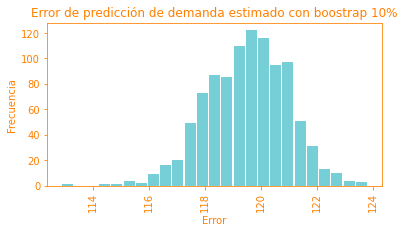

0    119.515085
dtype: float64
0    1.446346
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

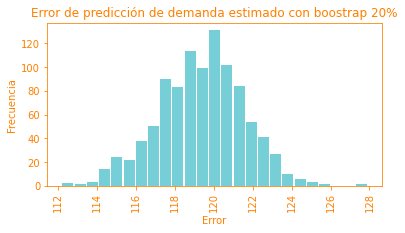

0    119.371446
dtype: float64
0    2.169213
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

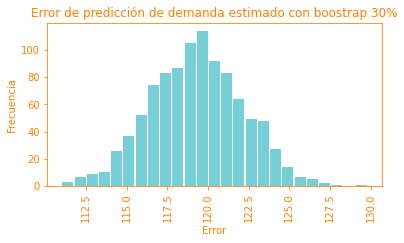

0    119.283215
dtype: float64
0    2.874147
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

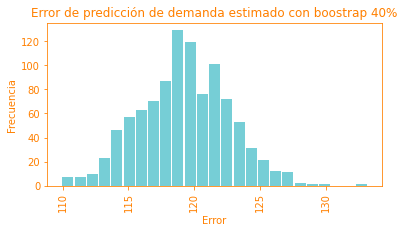

0    119.223624
dtype: float64
0    3.379523
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

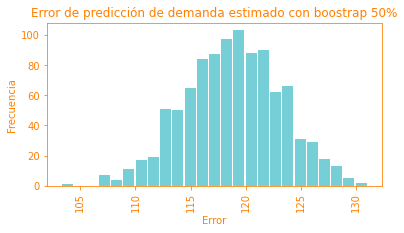

0    118.833097
dtype: float64
0    4.37359
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

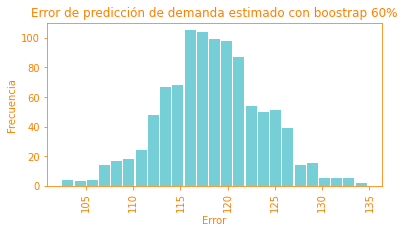

0    118.392715
dtype: float64
0    5.261031
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

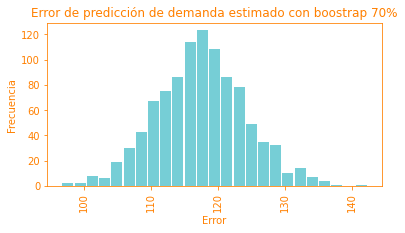

0    117.52569
dtype: float64
0    6.661608
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

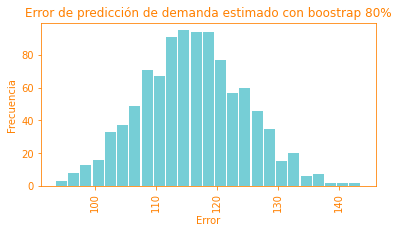

0    115.949509
dtype: float64
0    8.472154
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

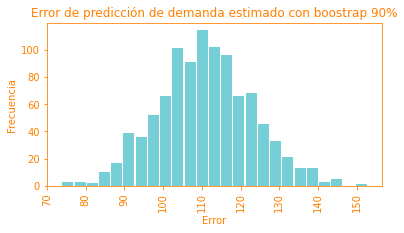

0    110.849971
dtype: float64
0    12.16591
dtype: float64


IndexError: ignored

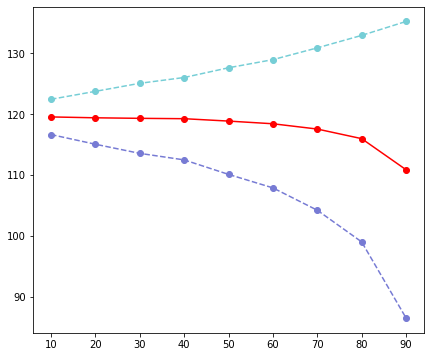

In [148]:
from numpy.ma.core import mean
replicas  = 1000 # porcentaje de muestreo 1500,2000,2500,5000
percent   = [10,20,30,40,50,60,70,80,90] # porcentaje de muestreo
ylist     = []

mean      = []
desv_up   = []
desv_down = []
for per in percent:
    bootstrap_ols = []
    for rep in range(replicas):
        a = np.arange(0,X.shape[0])
        b = np.sort(np.random.choice(a, replace=False, size = int(len(a) * (per/100))))
        X_train = np.delete(X, b, axis = 0)
        Y_train = np.delete(Y, b, axis = 0)            
        olsmod = sm.OLS(Y_train, X_train)
        olsres = olsmod.fit()
        Y_pred = olsres.predict(X_train)  
        bootstrap_ols.append(mean_absolute_error(Y_train, Y_pred))
    dfb = pd.DataFrame((np.asarray(bootstrap_ols)).T)
    bootstrap_mean = dfb.mean(numeric_only = True)
    bootstrap_std = dfb.std(numeric_only   = True)
    dibuja_hist2(dfb,colour='#76ced6',name='hist_t7_1.png',Xlabel="Error",Ylabel="Frecuencia",title="Error de predicción de demanda estimado con boostrap "+str(per)+"%")
    print(bootstrap_mean)
    print(bootstrap_std)

    mean.append(bootstrap_mean)
    desv_up.append(bootstrap_mean   + bootstrap_std*2)
    desv_down.append(bootstrap_mean - bootstrap_std*2)

    ylist.append(desv_up)
    ylist.append(mean)
    ylist.append(desv_down)

labels   = ['95%','media','5%']
Xlabel   = '% de muestreo'
Ylabel   = 'error'
title    = "Error en muestreo usando bootstrap"
namefile = 'fig_t7_5'
dibuja_lineas(percent, ylist, labels, namefile, Xlabel, Ylabel, title)

## Muestreo **cross-validation** en estimación de error en la predicción de demanda eléctrica usando regresión líneal múltiple
En esta función se calcula un modelo de regresión lineal múltiple para cada una de las una de las muestras `X_test` extraidas del total del conjunto de entrenamiento `X_train`. Los datos de error del muestreo cross-validation se guardan en la lista cross_ols.

In [ ]:
cross_ols_fx = []
nblocks    = 100
nblocks    = X.shape[0] 
print(X.shape[0] )
size = int( X.shape[0] / nblocks)
intervals = np.arange(size, X.shape[0], size)

for i in intervals:  
    a = np.arange(0,X.shape[0])
    b = np.arange(i-size,i)
    c = np.sort(np.setdiff1d(a, b)) #El complemento del conjunto seleccionado
    X_test  = np.delete(X, b, axis = 0)
    Y_test  = np.delete(Y, b, axis = 0)    
    X_train = np.delete(X, c, axis = 0)
    Y_train = np.delete(Y, c, axis = 0)

    olsmod  = sm.OLS(Y_train, X_train)
    olsres  = olsmod.fit()
    Y_pred  = olsres.predict(X_test)  
    error = abs(Y_test - Y_pred)
    cross_ols_fx.append(mean_absolute_error(Y_test,Y_pred))

dfb = pd.DataFrame((np.asarray(cross_ols_fx)).T)
cross_mean_fx = dfb.mean(numeric_only = True)
cross_std_fx = dfb.std(numeric_only = True)
dibuja_hist2(dfb,colour='#777bd4',name='hist_t7_2.png',Xlabel="Error",Ylabel="Frecuencia",title="Error de predicción de demanda estimado con Cross-validation")
print(cross_mean_fx)
print(cross_std_fx)

Esta versión de cross-validation elige aleatoriamente el inicio de las muestras de prueba X_test

In [ ]:
cross_ols = []
nblocks   = 300
size = int( X.shape[0] / nblocks)

replicas = 180
arr = np.sort(np.random.choice(a, replace=False, size = replicas))
print(arr)
for i in arr:

      a = np.arange(1,X.shape[0])
      b = np.arange(i-size,i)
      c = np.sort(np.setdiff1d(a, b)) #El complemento del conjunto seleccionado
      X_test  = np.delete(X, b, axis = 0)
      Y_test  = np.delete(Y, b, axis = 0)    
      X_train = np.delete(X, c, axis = 0)
      Y_train = np.delete(Y, c, axis = 0)

      olsmod  = sm.OLS(Y_train, X_train)
      olsres  = olsmod.fit()
      Y_pred  = olsres.predict(X_test)  
      error = abs(Y_test - Y_pred)
      cross_ols.append(mean_absolute_error(Y_test,Y_pred))

dfb = pd.DataFrame((np.asarray(cross_ols)).T)
cross_mean = dfb.mean(numeric_only = True)
cross_std = dfb.std(numeric_only = True)
dibuja_hist2(dfb,colour='#17cb49',name='hist_t7_3.png',Xlabel="Error",Ylabel="Frecuencia",title="Error de predicción de demanda estimado con Cross-validation")
print(cross_mean)
print(cross_std)